DD KolektorSDD2

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
import cv2
import os
import numpy as np

# Set the path to the dataset directory
train_dataset_dir = 'dataset/train/'
test_dataset_dir = 'dataset/test'

# Initialize empty arrays for storing the images and masks
images = []
masks = []

# Loop over the files in the dataset directory
for filename in os.listdir(train_dataset_dir):
    if filename.endswith('GT.png'): # Check if the file is an image
        mask_path = os.path.join(train_dataset_dir, filename)
        image_path = os.path.join(train_dataset_dir, filename[:-7]+'.png') # Assumes that the mask file is named "mask_<image_filename>.jpg"
        
        # Load the image and mask using OpenCV
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        
        # Convert the mask to a binary image
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.where(mask > 0, 1, 0)
        
        # Append the image and mask to the arrays
        images.append(image)
        masks.append(mask)
        
# Convert the image and mask arrays to numpy arrays
images = np.array(images)
masks = np.array(masks)

Visualisation of the dataset

In [69]:
import matplotlib.pyplot as plt
def show_images_with_masks(images, masks, start_index, end_index):
    fig, axs = plt.subplots(nrows=2, ncols=(end_index-start_index), figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i in range(start_index, end_index):
        image = images[i]
        mask = masks[i]

        axs[0, i-start_index].imshow(image, aspect='auto')
        axs[0, i-start_index].set_title(f"Image {i}")

        axs[1, i-start_index].imshow(mask, cmap='gray', aspect='auto')
        axs[1, i-start_index].set_title(f"Mask {i}")
        
    plt.show()

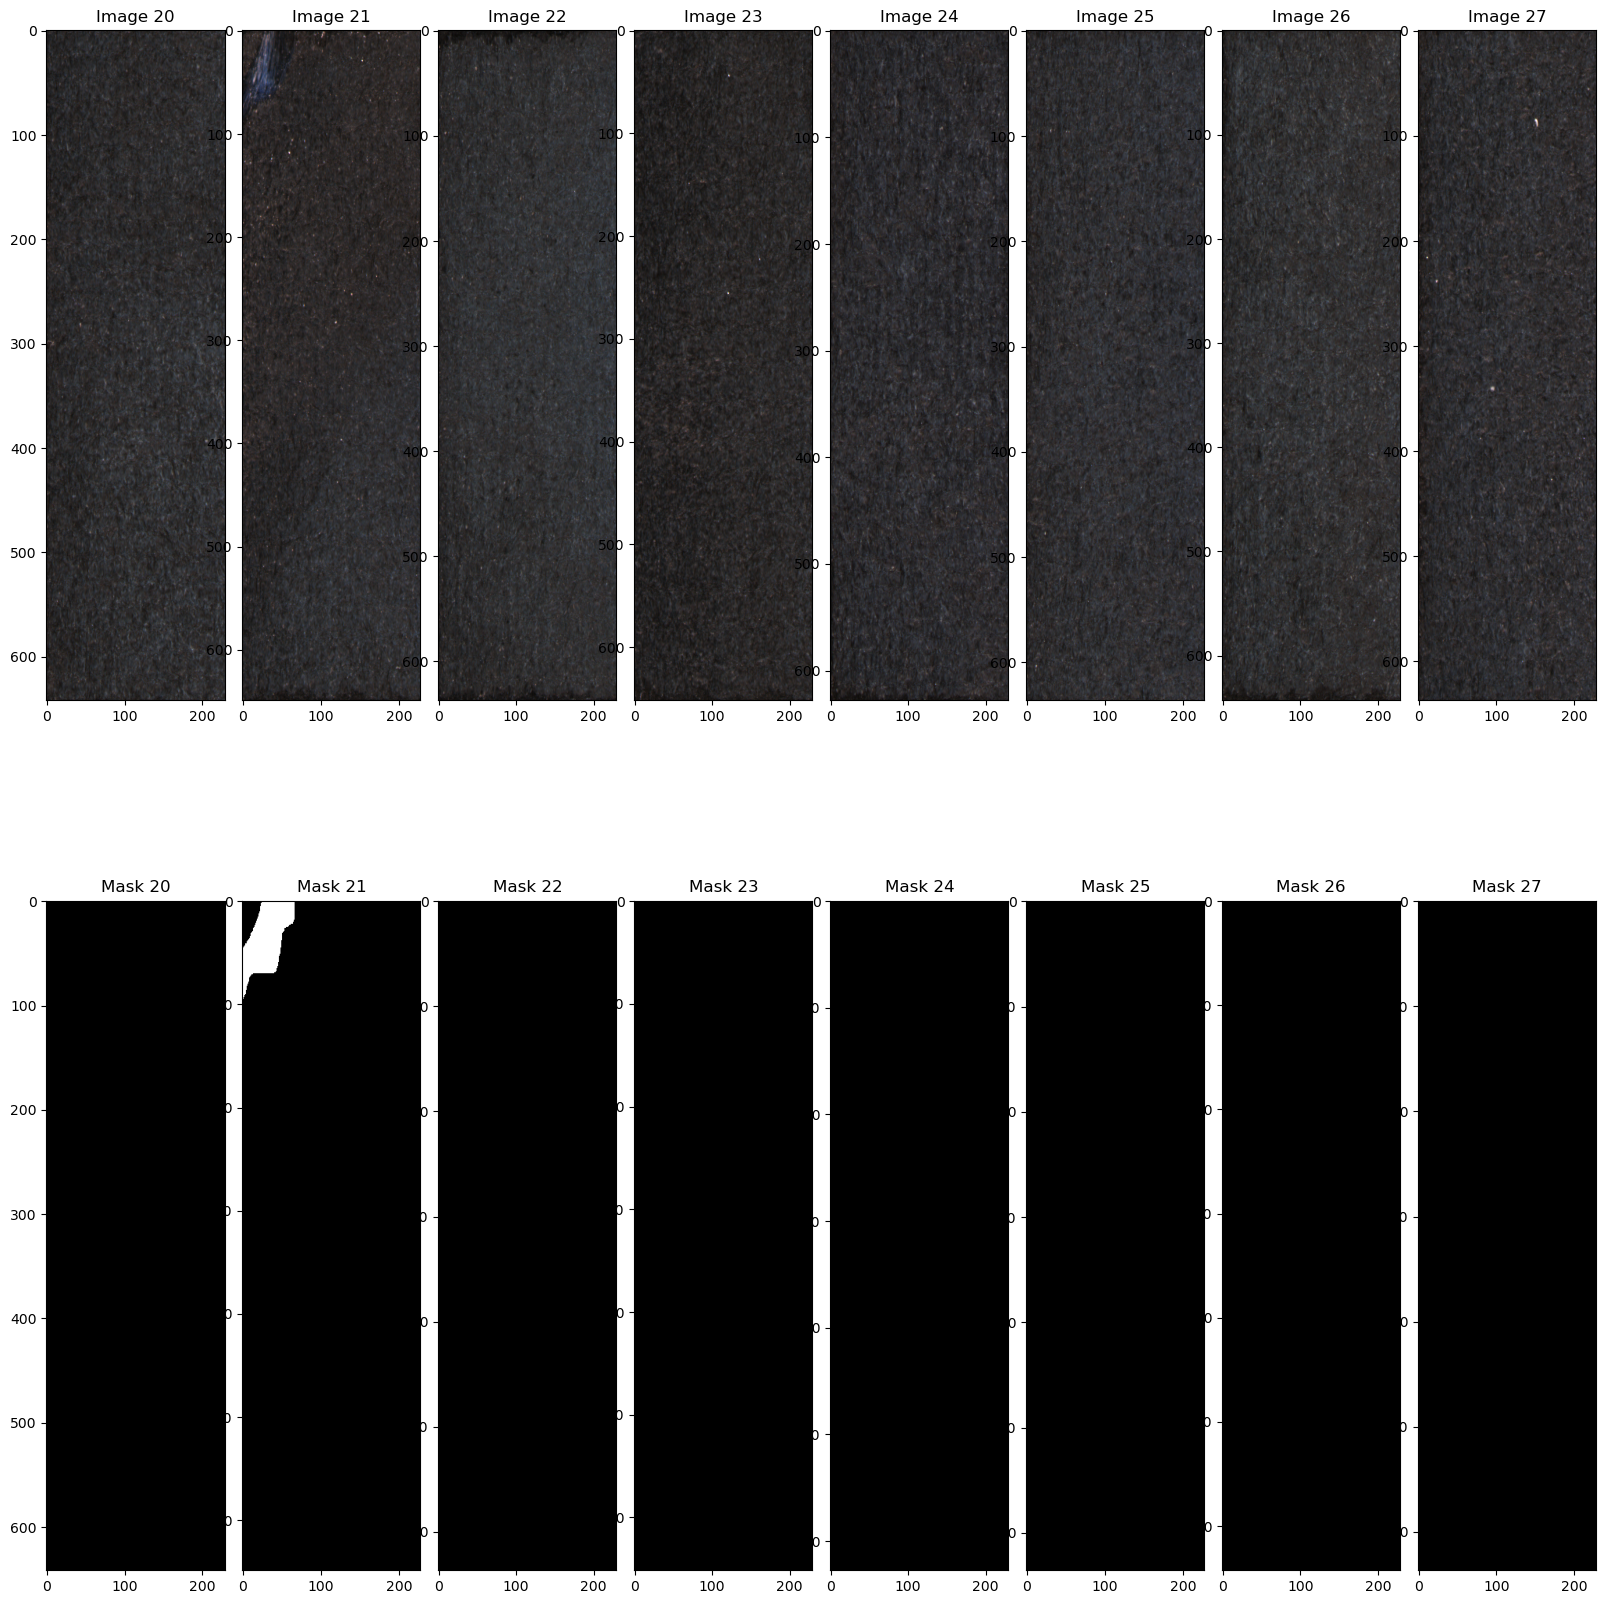

In [70]:
start_index = 20
num_imgs = 8
end_index = start_index + num_imgs

show_images_with_masks(images, masks, start_index, end_index)